# pytorch transformer implementation
(simplify)<br>
reference: https://blog.csdn.net/BXD1314/article/details/126187598

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

device  = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 100


## build vocabulary

In [4]:
# training dataset
sentences = [
    # enc_input               dec_input                   target_output
    ['我 有 一 个 好 朋 友 P', 'S I have a good friend .', 'I have a good friend . E'],
    ['我 有 零 个 女 朋 友 P', 'S I have zero girl friend .', 'I have zero girl friend . E'],
    ['我 有 一 个 男 朋 友 P', 'S I have a boy friend .', 'I have a boy friend . E']
]

src_vocab = {
    'P':0, '我':1, '有':2, '一':3, '个':4, '好':5, '朋':6, '友':7, '零':8, '女':9, '男':10
}
src_idx2word = {i:w for i,w in enumerate(src_vocab)}
src_vocab_size = len(src_vocab) # 11

tgt_vocab = {
    'S':0, 'I':1, 'have':2, 'a':3, 'good':4, 'friend':5, '.':6, 'zero':7, 'girl':8, 'boy':9, 'E':10, '.':11
}
tgt_idx2word = {i:w for i,w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab) # 12

src_len = 8 # enc_input max length
tgt_len = 7 # dec_input = dec_output, max length

# transformer parameters
d_model = 512    # token embedding dimension and position embedding dimension
d_ff = 2048      # feed forward dimension
d_k = d_v = 64   # dimension of K(=Q), V
n_layers = 6     # number of encoder and decoder layers
n_heads = 8      # number of heads in multi-head attention


## data preprocessing

In [9]:
def make_data(sentences):
    '''word sequence to index sequence'''
    enc_inputs, dec_inputs, dec_outputs = [], [], []
    for i in range(len(sentences)):
        enc_input = [[src_vocab[n] for n in sentences[i][0].split()]]
        dec_input = [[tgt_vocab[n] for n in sentences[i][1].split()]]
        dec_output = [[tgt_vocab[n] for n in sentences[i][2].split()]]

        enc_inputs.extend(enc_input)
        dec_inputs.extend(dec_input)
        dec_outputs.extend(dec_output)
    
    return torch.LongTensor(enc_inputs), torch.LongTensor(dec_inputs), torch.LongTensor(dec_outputs)

enc_inputs, dec_inputs, dec_outputs = make_data(sentences)
enc_inputs

tensor([[ 1,  2,  3,  4,  5,  6,  7,  0],
        [ 1,  2,  8,  4,  9,  6,  7,  0],
        [ 1,  2,  3,  4, 10,  6,  7,  0]])

In [10]:
class MyDataSet(Data.Dataset):
    def __init__(self, enc_inputs, dec_inputs, dec_outputs):
        super(MyDataSet, self).__init__()
        self.enc_inputs = enc_inputs
        self.dec_inputs = dec_inputs
        self.dec_outputs = dec_outputs

    def __len__(self):
        return self.enc_inputs.shape[0]  # shape:[3, 8]

    def __getitem__(self, idx):
        '''return one sample(enc_input, dec_input, dec_output)'''
        return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]
    
loader = Data.DataLoader(
    MyDataSet(enc_inputs, dec_inputs, dec_outputs),
    2,
    True,
)

## transformer model

### positional encoding
#### strategy: Sinusoidal Positional Encoding<br>
$PE_(pos, 2i) = sin(\frac{pos}{10000^{2i/d}})$ <br>
$PE_(pos, 2i+1) = cos(\frac{pos}{10000^{2i/d}})$
- pos: 序列中的位置(0, 1, 2, ...)<br>
- i: index of dimension (0, 1, ..., d-1)
- 偶数维用sin， 奇数维用cos
- $10000^{2i/d}$控制频率，保证不同维度有不同的周期

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1) # shape: [max_len, 1]，这样每一行是一个Pos
        '''e(2i * (-ln(10000)/d_model)) = e^(ln(1/10000^(2i/d_model))) = 1/10000^(2i/d_model)'''
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model
        ))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        '''
        pe shape: [max_len, d_model]
        unsqueeze(0) -> [1, max_len, d_model]
        transpose(0, 1) -> [max_len, 1, d_model]
        '''
        pe = pe.unsqueeze(0).transpose(0, 1) # [max_len, 1, d_model] 处理后可以直接和 token embedding 相加
        self.register_buffer('pe', pe) # 注册为模型的固定属性张量，非模型参数，但需要保存下来
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### masked matrix
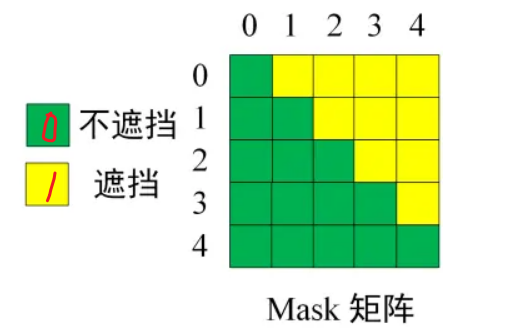

In [12]:
def get_attn_pad_mask(seq_q, seq_k):
    '''mask the padding token in sequences'''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1) # shape: [batch_size, 1, len_k], one is PAD token
    return pad_attn_mask.expand(batch_size, len_q, len_k) # shape: [batch_size, len_q, len_k]

def get_attn_subsequent_mask(seq):
    '''返回一个掩码矩阵，0代表可以访问，1代表被mask掉'''
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)] # [batch_size, seq_len, seq_len]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1) # upper triangular matrix of 1, masked
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask

### attention
$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$
- $d_k$ normalization
- Q, K decides the distribution of attention (weights)
- V decides the information to pass on (content itself)

**self-attention**<br>
encoder和decoder内部，len_q = len_k = seq_len，因为query和key来自同一序列<br>
**cross-attention**<br>
decoder的hidden states做query，encoder的hidden states做key/value:<br>
- K, V = encoder的输出len_k<br>
- Q = decoder的输出len_q

但是$K^\top$可以使其相乘，相当于每个decoder token都查询encoder的全部token<br>

**steps**
1. 计算$Q \cdot K^\top$
2. 加mask, 对于mask = True的，赋值无穷小，这样softmax后值为0，则与mask的信息无关
3. softmax 得到attention score
4. $attn * V$ attention score 和 value 相乘得到attention layer的输出

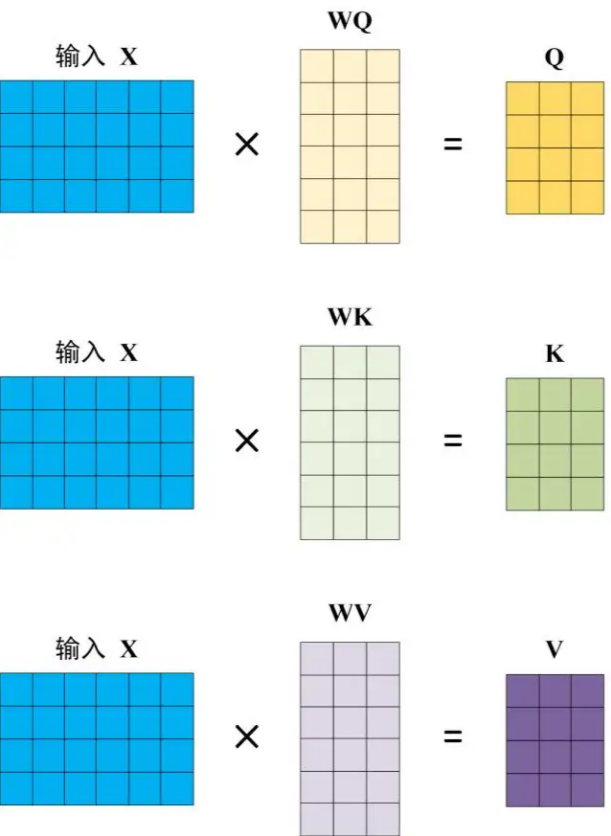

In [15]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v (=len_k), d_k]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores: [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9)  # fill elements of self tensor with negative infinite value where mask is true

        attn = nn.Softmax(dim=-1)(scores) # 沿最后一维做softmax，对每个query(i)，对所有key(j=0, 1, 2, ..., len_k-1)计算概率分布
        context = torch.matmul(attn, V) # context: [batch_size, n_heads, len_q, d_k]
        return context, attn

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias = False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias = False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias = False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias = False)   # FC保证attention的输出仍然是[len_q, d_model]

    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q:[batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]   seq_len = len_q
        '''
        residual = input_Q
        batch_size = input_Q.size(0)

        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # Q:[batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # K:[batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # V:[batch_size, n_heads, len_v(=len_k), d_k]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)  # [batch_size, seq_len, seq_len] -> [batch_size, n_heads, seq_len, seq_len]

        # context, attn = ScaledDotProductAttention()
        attention = ScaledDotProductAttention()
        context, attn = attention(Q, K, V, attn_mask) # context:[batch_size, n_heads, seq_len, d_k]

        # 将不同的head拼接在一起  context:[batch_size, seq_len, n_heads * d_v]
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v)

        output = self.fc(context)
        return nn.LayerNorm(d_model).to(device)(output + residual), attn

### Feed Forward
MLP 升维->降维

In [ ]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(n_model, d_ff, bias = False),
            nn.ReLU(),
            nn.Linear(n_ff, n_module, bias = False)
        )

    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).to(device)(output + residual)

In [17]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_maks)
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForward()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn     

## architecture

### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__():
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''enc_inputs: [batch_size, src_len]'''
        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1)
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

### Decoder

### Transformer